# Week 12 - Variational inference - Bayesian Gaussian Mixture Model

Hello again. Welcome to week 12! In this week, you will learn about Variational inference.

The usual imports...

In [1]:
import numpy as np
from scipy.stats import norm
from matplotlib import pyplot as plt

# fix random generator seed (for reproducibility of results)
np.random.seed(42)

# matplotlib options
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12, 8)

In [2]:
# matplotlib options (for some reason, in many computers, needs to be run twice to take effect...)
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12, 8)

## Generate artificial data: Ancestral sampling

In this notebook, we shall consider a simple Bayesian Gaussian mixture model corresponding to the following generative process:

1. For each cluster $k \in \{1,\dots,K)$:
    2. Draw cluster center $\mu_k \sim \mathcal{N}(\mu_k|0, \tau^2)$
3. For each data point $1,\dots,N$:
    4. Draw cluster assignment $z_n \sim \mbox{Multinomial}(z_n|\boldsymbol\pi)$
    5. Draw observed data point $x_n \sim \mathcal{N}(x_n|\mu_{z_n}, \sigma^2)$

For the sake of simplicity, we shall assume the values of $\boldsymbol\pi$, $\tau^2$ and $\sigma^2$ to be given.

In [3]:
tau = 10
tau2 = tau**2
sigma = 0.5
sigma2 = sigma**2
pi = np.array([0.2,0.3,0.5])

We can now use ancestral sampling to sample from our Bayesian linear regression model:

In [4]:
N = 100
K = 3

mu = np.zeros(K)
for k in range(K):
    # sample cluster centers
    mu[k] = np.random.normal(0, tau)

print("true mu:", mu)
    
z = np.zeros(N)
x = np.zeros(N)
for n in range(N):
    # sample cluster assignment
    z_n = np.argmax(np.random.multinomial(1, pi))
    z[n] = z_n # save true z_n's just for debug
    
    # sample observed data point (accordint to cluster assignment)
    x[n] = np.random.normal(mu[z_n], sigma)

mu: [ 4.96714153 -1.38264301  6.47688538]


We can visualize the distribution of our $N$ sampled observations $\{x_1,\dots,x_N\}$:

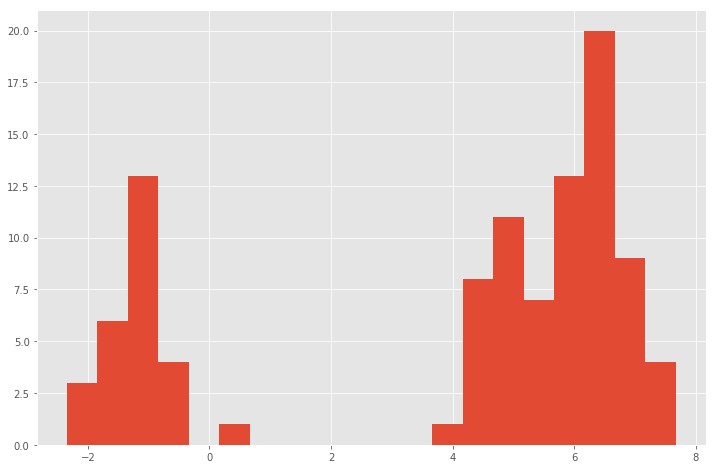

In [5]:
plt.hist(x, bins=20)
plt.show()

## Variational inference

### Step 1: Setup

The joint distribution is given by (ignoring the fixed parameters):

\begin{align}
    p(\boldsymbol\mu, \textbf{z}, \textbf{x}) &= \Bigg( \prod_{k=1}^K \mathcal{N}(\mu_k|0,\tau^2) \Bigg)  \, \prod_{n=1}^N \mbox{Mult}(z_n|\boldsymbol\pi) \, \mathcal{N}(x_n|\mu_{z_n})
\end{align}

where $\boldsymbol\mu = \{\mu_1,\dots,\mu_K\}$, $\textbf{x} = \{x_1,\dots,x_N\}$ and $\textbf{z} = \{z_1,\dots,z_N\}$.

Our goal is to compute the posterior over $\boldsymbol\mu$ and $\textbf{x}$:

\begin{align}
    p(\boldsymbol\mu, \textbf{z} | \textbf{x}) = \frac{p(\boldsymbol\mu, \textbf{z}, \textbf{x})}{\int_{\boldsymbol\mu} \sum_{\textbf{z}} p(\boldsymbol\mu, \textbf{z}, \textbf{x})} \nonumber
\end{align}

In variational inference, namely in mean-field variational inference, we approximate $p(\boldsymbol\mu, \textbf{z} | \textbf{x})$ with a fully-factorized distribution $q(\boldsymbol\mu, \textbf{z})$:

\begin{align}
    q(\boldsymbol\mu, \textbf{z}) = \Bigg( \prod_{k=1}^K \mathcal{N}(\mu_k|\tilde{\mu}_k,\tilde{\sigma}_k) \Bigg)  \, \prod_{n=1}^N \mbox{Mult}(z_n|\boldsymbol\phi_n)\nonumber
\end{align}

Our goal is to find the variational parameters $\tilde\mu_k$, $\tilde\sigma_k$ and $\boldsymbol\phi_n$ that maximize the ELBO $\mathcal{L}(q)$:

\begin{align}
	\mathcal{L}(q) &= \mathbb{E}_q[ \log p(\boldsymbol\mu, \textbf{z}, \textbf{x}) ] - \mathbb{E}_q[ \log q(\boldsymbol\mu, \textbf{z}) ] \nonumber
\end{align}

### Step 2: Computing the ELBO

Because $q$ is fully factorized, the expectations in $\mathcal{L}(q)$ decompose into sums of simpler terms:

\begin{align}
	\mathbb{E}_q[ \log p(\boldsymbol\mu, \textbf{z}, \textbf{x}) ] = \sum_{k=1}^K \mathbb{E}_q[\log \mathcal{N}(\mu_k|0,\tau^2)] + \sum_{n=1}^N \mathbb{E}_q[\log \mbox{Mult}(z_n|\boldsymbol\pi)] + \sum_{n=1}^N \mathbb{E}_q[\log \mathcal{N}(x_n|\mu_{z_n},\sigma^2) ]\nonumber
\end{align}

\begin{align}
	\mathbb{E}_q[ \log q(\boldsymbol\mu, \textbf{z}) ] &= \sum_{k=1}^K \mathbb{E}_q[\log \mathcal{N}(\mu_k|\tilde{\mu}_k,\tilde{\sigma}_k)] + \sum_{n=1}^N \mathbb{E}_q[\log \mbox{Mult}(z_n|\boldsymbol\phi_n)] \nonumber
\end{align}

Now, we have to compute the required terms (expectations). It is a bit cumbersome, but generally easy... (Note: be careful not to confuse the mixing proportions parameter $\boldsymbol\pi = \{\pi_1,\dots,\pi_k\}$ with the value of $\pi$ that comes from the PDF of the Gaussian :-)

\begin{align}
	\mathbb{E}_q[\log \mathcal{N}(\mu_k|0,\tau^2)] &= \mathbb{E}_q\Bigg[\log \Bigg( \frac{1}{\sqrt{2\pi\tau^2}} \, \exp{ \bigg(-\frac{\mu_k^2}{2\tau^2}\bigg) } \Bigg)\Bigg] = -\frac{1}{2}\log (2\pi\tau^2) - \frac{\mathbb{E}_q[\mu_k^2]}{2\tau^2}\nonumber\\
    \mathbb{E}_q[\log \mbox{Mult}(z_n|\boldsymbol\pi)] &= \mathbb{E}_q\Bigg[\log \prod_{i=1}^K (\pi_i)^{z_{n,i}}\Bigg] = \sum_{i=1}^K \phi_{n,i} \, \log \pi_i \nonumber\\
    \mathbb{E}_q[\log \mathcal{N}(x_n|\mu_{z_n},\sigma^2)] &= \mathbb{E}_q\Bigg[\log \Bigg( \frac{1}{\sqrt{2\pi\sigma^2}} \, \exp{ \bigg(-\frac{(x_n - \mu_{z_n})^2}{2\sigma^2}\bigg) } \Bigg)\Bigg] = -\frac{1}{2}\log (2\pi\sigma^2) - \frac{x_n^2}{2\sigma^2} + \frac{x_n \mathbb{E}_q[\mu_{z_n}]}{2\sigma^2} - \frac{\mathbb{E}_q[\mu_{z_n}^2]}{2\sigma^2}\nonumber\\ \nonumber\\
    \mathbb{E}_q[\log \mathcal{N}(\mu_k|\tilde{\mu}_k,\tilde\sigma_k^2)] &= \mathbb{E}_q\Bigg[\log \Bigg( \frac{1}{\sqrt{2\pi\tilde\sigma_k^2}} \, \exp{ \bigg(-\frac{(\mu_k - \tilde\mu_k)^2}{2\tilde\sigma_k^2}\bigg) } \Bigg)\Bigg] = -\frac{1}{2}\log (2\pi\tilde\sigma_k^2) - \frac{1}{2} \nonumber\\
    \mathbb{E}_q[\log \mbox{Mult}(z_n|\boldsymbol\phi)] &= \mathbb{E}_q\Bigg[\log \prod_{i=1}^K (\phi_i)^{z_{n,i}}\Bigg] = \sum_{i=1}^K \phi_{n,i} \, \log \phi_{n,i} \nonumber
\end{align}

where

\begin{align}
	\mathbb{E}_q[\mu_k] &= \tilde\mu_k \nonumber\\
	\mathbb{E}_q[\mu_k^2] &= \tilde\sigma_k^2 + \tilde\mu_k^2 \nonumber\\
	\mathbb{E}_q[\mu_{z_n}] &= \sum_{i=1}^K \phi_{n,i} \, \tilde\mu_i \nonumber\\
	\mathbb{E}_q[\mu_{z_n}^2] &= \sum_{i=1}^K \phi_{n,i} \, (\tilde\sigma_k^2 + \tilde\mu_k^2) \nonumber
\end{align}

Now that have determined the expressions for all the terms, we cam compute the ELBO in python. Careful, as this is quite error-prone...

In [6]:
def elbo(phi, mu_tilde, sigma_tilde):
    lb = 0.0
    
    for k in range(K):
        lb += -.5*np.log(2*np.pi*tau2) - (sigma2_tilde[k] + mu_tilde[k]**2)/(2*tau2)
        lb += -.5*np.log(2*np.pi*sigma2_tilde[k]) - .5

    for n in range(N):
        lb += np.sum(phi[n,:] * np.log(pi))
        lb += -.5*np.log(2*np.pi*sigma2) - (x[n]**2)/(2*sigma2) + (np.sum(phi[n,:] * mu_tilde)*x[n])/sigma2 - np.sum(phi[n,:] * (sigma2_tilde + mu_tilde**2))/(2*sigma2)
        lb += np.sum(np.ma.filled(phi[n,:] * np.ma.log(phi[n,:]), 0))

    return lb

### Step 3: Determining the coordinate ascent updates

We now have an analytical expression for our evidence lower bound (ELBO), $\mathcal{L}(q)$. Our next step is maximize it with respect to the variational parameters $\tilde\mu_k$, $\tilde\sigma_k$ and $\boldsymbol\phi_n$. For that, we shall use coordinate ascent.

In coordinate ascent, we iteratively optimize each of the variational parameters in $q(\boldsymbol\mu, \textbf{z})$ in turn, holding the others fixed, until a convergence criteria is met. 

In order to maximize the ELBO with respect to a variational parameter, we find the terms in the ELBO $\mathcal{L}(q)$ that contain it, and then we take derivatives of the ELBO with respect to that parameter:

\begin{align}
	\frac{\partial \mathcal{L}(q)}{\partial \tilde\mu_k} &= \, ?\nonumber
\end{align}

\begin{align}
	\frac{\partial \mathcal{L}(q)}{\partial \tilde\sigma_k} &= \, ?\nonumber
\end{align}

\begin{align}
	\frac{\partial \mathcal{L}(q)}{\partial \tilde\phi_{n,k}} &= \, ?\nonumber
\end{align}

Finally, we set the derivatives to zero in order to find the optimum (i.e. the coordinate ascent updates):

\begin{align}
	\tilde\mu_k &= \, ?\nonumber
\end{align}

\begin{align}
	\tilde\sigma_k &= \, ?\nonumber
\end{align}

\begin{align}
	\tilde\phi_{n,k} &= \, ?\nonumber
\end{align}

Note: Since the parameters $\phi_{n,k}$ are required to sum to 1, i.e. $\sum_{k=1}^K \phi_{n,k} = 1$, we will use Lagrange multipliers to ensure that constraint. If you haven't used Lagrange multiplers of this type before, you will see that it is quite easy :-)

### Step 4: Implementation

Once we determined closed-form solution for the coordinate ascent updates (note that this is not always possible!!), we are ready to implement variational inference algorithm.

We start by initializing the variational parameters $\tilde\mu_k$, $\tilde\sigma_k$ and $\boldsymbol\phi_n$. A reasonable initialization can be very important!!

In [7]:
# create data structures for keeping variational parameters
mu_tilde = np.zeros(K)
sigma2_tilde = np.zeros(K)
phi = np.zeros((N,K))

# initialize variational parameters
for k in range(K):
    mu_tilde[k] = np.random.uniform(x.min(), x.max())
    sigma2_tilde[k] = np.var(x)
for n in range(N):
    phi[n] = np.random.multinomial(1, pi)
    
print("initial mu_tilde:", mu_tilde)
print("initial sigma2_tilde:", sigma2_tilde)

elbo_values = [elbo(phi, mu_tilde, sigma2_tilde)] # array to store the elbo values for all the VI iterations
print("initial elbo:", elbo_values[0])

initial mu_tilde: [ 5.62051425  0.36993171  2.05358184]
initial sigma2_tilde: [ 10.33868707  10.33868707  10.33868707]
initial elbo: -5418.12451573


We now run the coordinate ascent updates iteratively, until a convergence criteria is met. In this case, we stop when the difference of the ELBO between two consecutive iterations is less than a threshold.

In [8]:
# run variational inference
THRESHOLD = 0.1

iteration = 0
while True:
    iteration += 1
    
    # TODO: update variational parameters
    raise Exception("TODO")
    
    # print variational parameters (except phi_n)
    print("\niteration:", iteration)
    print("mu_tilde:", mu_tilde)
    print("sigma2_tilde:", sigma2_tilde)
    
    # compute value of the elbo
    lb = elbo(phi, mu_tilde, sigma2_tilde)
    print("elbo:", lb)
    
    elbo_values += [lb] # keep track of all elbo values
    
    # check if the VI algorithm has converged
    if (elbo_values[-1] - elbo_values[-2]) < THRESHOLD:
        break


iteration: 1
mu_tilde: [ 4.10984725  3.75834161  4.01615387]
sigma2_tilde: [ 0.01086838  0.00861995  0.00520806]
elbo: -2119.42018606

iteration: 2
mu_tilde: [ 6.05540782 -0.23571815  5.74863113]
sigma2_tilde: [ 0.00824782  0.00796293  0.00652724]
elbo: -334.131328098

iteration: 3
mu_tilde: [ 6.36111646 -1.16193491  5.62541386]
sigma2_tilde: [ 0.01080943  0.0092584   0.00501233]
elbo: -254.803594526

iteration: 4
mu_tilde: [ 6.57116531 -1.16193491  5.4493611 ]
sigma2_tilde: [ 0.00938967  0.0092584   0.00539025]
elbo: -235.049912555

iteration: 5
mu_tilde: [ 6.59899369 -1.16193491  5.35648107]
sigma2_tilde: [ 0.00847582  0.0092584   0.00574589]
elbo: -230.404284405

iteration: 6
mu_tilde: [ 6.58587075 -1.16193491  5.3095674 ]
sigma2_tilde: [ 0.00796223  0.0092584   0.00600864]
elbo: -228.697864889

iteration: 7
mu_tilde: [ 6.57350249 -1.16193491  5.28080635]
sigma2_tilde: [ 0.00766299  0.0092584   0.00619108]
elbo: -227.714152709

iteration: 8
mu_tilde: [ 6.56519803 -1.16193491  5.262

Notice how fast this VI algorithm is compared to running MCMC (e.g. NUTS) or even ADVI in STAN! But, remember that this is a specialized inference algorithm that we derived and implemented just for this model. On the other hand, NUTS and ADVI are general algorithms that work for **any** model that you specify! (well, at least ignoring the discrete latent variables limitation...)

A good advice is to always plot the evolution of the ELBO over the iterations. 

Notice that the curve should be monotonically increasing. The ELBO should never decrease between two consecutive iterations! If it does, then we made a mistake somewhere :-)

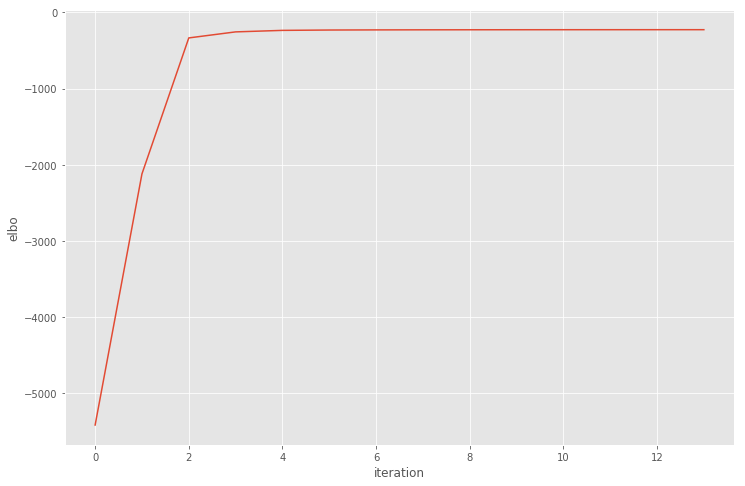

In [9]:
plt.plot(elbo_values)
plt.xlabel("iteration")
plt.ylabel("elbo")
plt.show()

Lastly, we can visualize the approximate posterior distributions for the means $q(\mu_k|\tilde\mu_k,\tilde\sigma_k^2)$ and compare them with the true means $\mu_k$ that we used to generate the data in the ancestral sampling procedure. This is another great check for debugging your derivations and implementation!

This is why ancestral sampling is so useful. We use it to generate artificial data, but since the data is artificially generated, we know the true values of latent variables that we are trying to infer. Therefore, we can use it to check if our inference algorithm is able to recover the true values, or at least approximate them well :-)

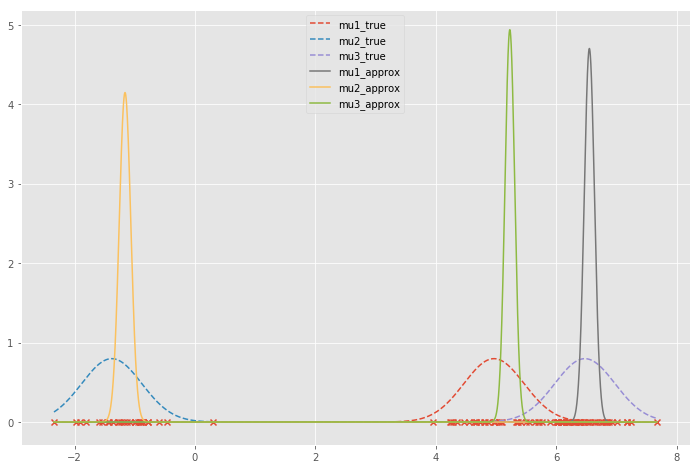

In [12]:
pts = np.arange(x.min(), x.max(), 0.001)
for k in range(K):
    plt.plot(pts, norm.pdf(pts, mu[k], sigma), ls='dashed')
for k in range(K):
    plt.plot(pts, norm.pdf(pts, mu_tilde[k], np.sqrt(sigma2_tilde[k])))
plt.scatter(x, np.zeros(N), marker='x')
plt.legend(["mu%d_true" % (k+1,) for k in range(K)] + ["mu%d_approx" % (k+1,) for k in range(K)])
plt.show()

In this case, we can observe that the mean of approximate distribution $q$ is fairly close to the true mean, but the variance is bit off. Specifically, we can observe that the approximate distribution is overly confident. This is a typical property of variational inference! (Check slide 11 of Lecture 12 for details)